In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [21]:
train_fpath = "mnist_traindata.hdf5"

with h5py.File(train_fpath, 'r') as hf:
    X_data = hf["xdata"][:]
    y_data = hf["ydata"][:]

X_train = X_data[:50000]
y_train = y_data[:50000]

X_valid = X_data[10000:]
y_valid = y_data[10000:]

# Problem 2

## Part a)
### For part a), refer to code below for learning rate decay.

In [35]:
class NN:

    def __init__(self, architecture, X_train, y_train, X_valid, y_valid, batch_size, learning_rate, epochs):
        self.architecture = architecture
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_deriv(self, x):
        z = self._tanh(x)
        return 1-z**2

    def _ReLU(self, x):
        return np.maximum(x, 0)

    def _ReLU_deriv(self, x):
        z = x.copy()
        z[x <= 0] = 0
        z[x > 0] = 1
        return z

    def _softmax(self, x):
        return np.exp(x)/(np.sum(np.exp(x)))

    def _softmax_deriv(self, x):
        z = self._softmax(x)
        return z*(1-z)


    def _initialize(self):
        self.network_params = {}

        for i, v in enumerate(self.architecture):
            input_neurons = v["input_neurons"]
            output_neurons = v["output_neurons"]
            activation = v["activation"]
            h = None
            dh = None

            if activation == "relu":
                h = self._ReLU
                dh = self._ReLU_deriv
            elif activation == "tanh":
                h = self._tanh
                dh = self._tanh_deriv
            elif activation == "softmax":
                h = self._softmax
                dh = self._softmax_deriv
            else:
                raise Exception("Unsupported or invalid format activation.")

            W = np.sqrt(2/input_neurons)*np.random.randn(output_neurons, input_neurons)
            b = np.sqrt(2/input_neurons)*np.random.randn(output_neurons, 1)

            self.network_params[f"W{i+1}"] = W
            self.network_params[f"b{i+1}"] = b
            self.network_params[f"h{i+1}"] = h
            self.network_params[f"dh{i+1}"] = dh

    def forward_prop(self, X):
        A_curr = X.copy()
        layer_params = {}

        for i in range(len(self.architecture)):
            A_prev = A_curr
            W = self.network_params[f"W{i+1}"]
            b = self.network_params[f"b{i+1}"]
            h = self.network_params[f"h{i+1}"]

            S_curr = np.dot(W, A_prev)+b
            A_curr = h(S_curr)

            layer_params[f"S{i+1}"] = S_curr
            layer_params[f"A{i}"] = A_prev

        return A_curr, layer_params

    def _cross_entropy_loss(self, target, output):
        return -(1/np.size(target, axis=0))*(np.dot(target, np.log(output).T)+np.dot(1-target, np.log(1-output).T))

    def back_prop(self, y_hat, y, layer_params):
        gradients = {}
        dA_prev = -(1/np.size(y, axis=0))*(np.divide(y, y_hat.T)-np.divide(1-y,1-y_hat.T)).T

        for i, layer in reversed(list(enumerate(self.architecture))):
            i_curr = i+1
            dA_curr = dA_prev

            A_prev = layer_params[f"A{i}"]
            S_curr = layer_params[f"S{i_curr}"]

            W_curr = self.network_params[f"W{i_curr}"]
            b_curr = self.network_params[f"b{i_curr}"]
            dh = self.network_params[f"dh{i_curr}"]

            dS_curr = dA_curr*dh(S_curr)/np.size(A_prev, axis=1)
            dW_curr = np.dot(dS_curr, A_prev.T)
            db_curr = np.sum(dS_curr, axis=1, keepdims=True)
            dA_prev = np.dot(W_curr.T, dS_curr)

            gradients[f"dW{i_curr}"] = dW_curr
            gradients[f"db{i_curr}"] = db_curr

        return gradients

    def accuracy(self, y_hat, y_true):
        y_without_one_hot = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_hat.T, axis=1)
        return np.sum(np.isclose(y_pred, y_without_one_hot))/np.size(y_without_one_hot)

    def _mini_batch_sgd(self):
        indices = np.arange(np.size(self.X_train, axis=0))
        np.random.shuffle(indices)
        
        shuffled_X_train = np.take(self.X_train, indices, axis=0)
        shuffled_y_train = np.take(self.y_train, indices, axis=0)
        X_train_mbs = np.split(shuffled_X_train, np.size(self.X_train, axis=0)/self.batch_size)
        y_train_mbs = np.split(shuffled_y_train, np.size(self.X_train, axis=0)/self.batch_size)

        for X_train_mb, y_train_mb in zip(X_train_mbs, y_train_mbs):
            y_hat_train_mb, mem_mb = self.forward_prop(X_train_mb.T)
            gradients = self.back_prop(y_hat_train_mb, y_train_mb, mem_mb)

            for i in range(len(self.architecture)):
                self.network_params[f"W{i+1}"] += self.learning_rate*gradients[f"dW{i+1}"]
                self.network_params[f"b{i+1}"] += self.learning_rate*gradients[f"db{i+1}"]

    def fit(self, randomize_lr_div=False):
        self._initialize()
        
        first_epoch = 0
        second_epoch = 0
        if randomize_lr_div:
            first_epoch = np.random.randint(0, self.epochs-1)
            second_epoch = np.random.randint(first_epoch, self.epochs)
        else:
            first_epoch = 19
            second_epoch = 39

        train_accuracies = np.zeros((self.epochs,))
        valid_accuracies = np.zeros((self.epochs,))
        for i in range(self.epochs):
            self._mini_batch_sgd()

            if i == first_epoch or i == second_epoch:
                self.learning_rate /= 2

            y_hat_train, layer_params_train = self.forward_prop(self.X_train.T)
            y_hat_valid, layer_params_valid = self.forward_prop(self.X_valid)
            train_accuracy = self.accuracy(y_hat_train, self.y_train)
            valid_accuracy = self.accuracy(y_hat_valid, self.y_valid)

            train_accuracies[i] = train_accuracy
            valid_accuracies[i] = valid_accuracy

        return self.network_params, (first_epoch, second_epoch), train_accuracies, valid_accuracies

## Part b)

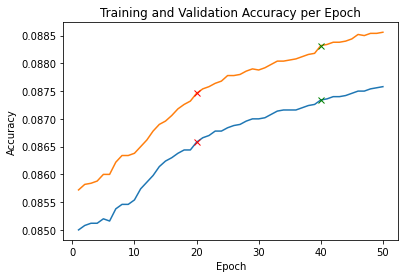

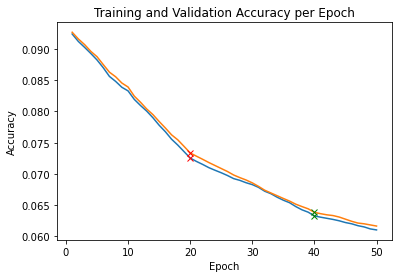

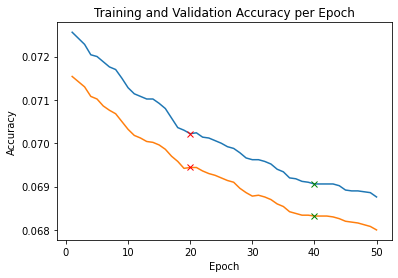

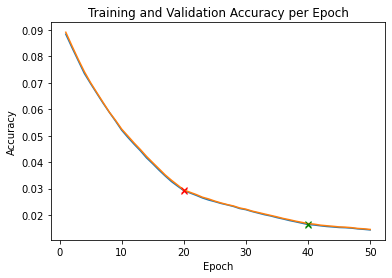

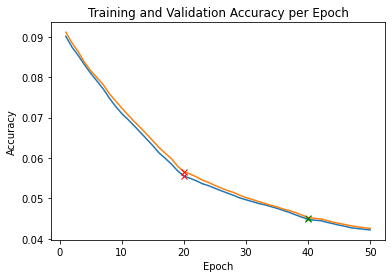

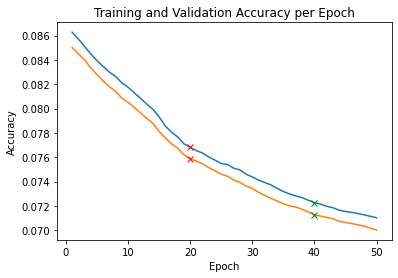

In [36]:
from itertools import product

batch_size = 250
lrs = [0.1, 0.05, 0.01]
activations = ["relu", "tanh"]
epochs = 50

hyperparam_map = {}
for (a, lr) in product(activations, lrs):
    architecture = [
        {"input_neurons": 784, "output_neurons": 200, "activation": a},
        {"input_neurons": 200, "output_neurons": 100, "activation": a},
        {"input_neurons": 100, "output_neurons": 10, "activation": "softmax"}
    ]

    nn = NN(architecture, X_train, y_train, X_valid.T, y_valid, batch_size, lr, epochs)
    network_params, (first, second), train_accuracies, valid_accuracies = nn.fit()

    hyperparam_map[f"model:{a}:{lr}"] = nn
    hyperparam_map[f"train_accuracy:{a}:{lr}"] = train_accuracies[-1]
    hyperparam_map[f"valid_accuracy:{a}:{lr}"] = valid_accuracies[-1]

    plt.figure()
    plt.plot(np.arange(1, epochs+1), train_accuracies)
    plt.plot(first+1, train_accuracies[first], 'rx')
    plt.plot(second+1, train_accuracies[second], 'gx')
    plt.plot(np.arange(1, epochs+1), valid_accuracies)
    plt.plot(first+1, valid_accuracies[first], 'rx')
    plt.plot(second+1, valid_accuracies[second], 'gx')
    plt.title("Training and Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

plt.show()

## Part c)

In [40]:
test_fpath = "mnist_testdata.hdf5"

with h5py.File(test_fpath, 'r') as hf:
    X_data = hf["xdata"][:]
    y_data = hf["ydata"][:]

X_test = X_data[:50000]
y_test = y_data[:50000]

valid_accuracies = {key: val for key, val in hyperparam_map.items() if "valid" in key}
max_valid_key = max(valid_accuracies, key=valid_accuracies.get)
key_split = max_valid_key.split(':')
best_a = key_split[1]
best_lr = key_split[2]
best_model = hyperparam_map[f"model:{a}:{lr}"]
y_hat_test, layer_params_test = best_model.forward_prop(X_test.T)
best_accuracy = best_model.accuracy(y_hat_test, y_test)
print(f"The best model has activation function: {best_a} and learning rate: {best_lr} which results in a testing accuracy of: {best_accuracy}.")

The best model has activation function: relu and learning rate: 0.1 which results in a testing accuracy of: 0.0659.
